In [7]:
import torch
import numpy as np
import scanpy as sc
import seaborn as sns
import scipy
import pandas as pd
import muon as mu

import matplotlib.pyplot as plt
import matplotlib.colors as clt


import warnings
warnings.filterwarnings("ignore")


In [2]:
mdata=mu.read("/data/nelkazwi/lymphoma_data/mdata_lymphoma.h5mu")
mdata

MuData object with n_obs × n_vars = 14566 × 33907
  var:	'n_cells'
  obsm:	'X_mofa', 'X_umap'
  varm:	'LFs'
  obsp:	'connectivities', 'distances'
  2 modalities
    atac:	14566 x 25812
      obs:	'cell_types'
      var:	'n_cells'
    rna:	14566 x 8095
      obs:	'cell_types'
      var:	'gene_ids', 'feature_types', 'n_cells'

In [4]:
t=45
theta=torch.load("/scratch/nelkazwi/lymphoma_data/"+str(t)+"_topics/theta_"+str(t)+".txt",map_location=torch.device('cpu'))
m=theta[50:,:,:].mean(axis=0)
m=m/m.sum(axis=1)[:,np.newaxis] 
lam=torch.load("/scratch/nelkazwi/lymphoma_data/"+str(t)+"_topics/lam_"+str(t)+".txt",map_location=torch.device('cpu'))
m_lam=lam[50:,:,:].mean(axis=0)
phi=torch.load("/scratch/nelkazwi/lymphoma_data/"+str(t)+"_topics/phi_"+str(t)+".txt",map_location=torch.device('cpu'))
m_phi=phi[50:,:,:].mean(axis=0)

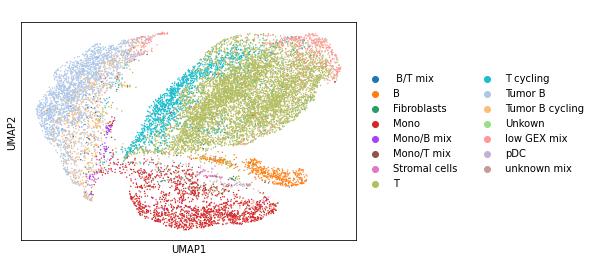

In [5]:
mdata["rna"].obsm["SHARE_Topic"]=m.numpy()
sc.pp.neighbors(mdata["rna"], use_rep="SHARE_Topic")
sc.tl.umap(mdata["rna"])
rna=mdata["rna"]
fig=sc.pl.umap(rna,color=["cell_types"],title=" ",return_fig=True, legend_fontweight='bold')

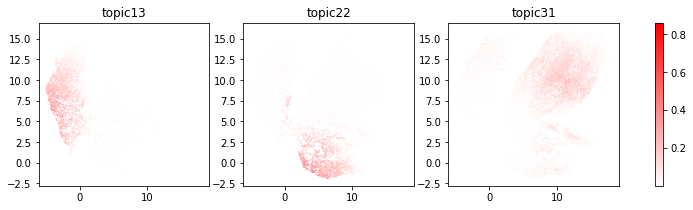

In [23]:
k=[12,21,30]
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(13,3))
cmap = clt.LinearSegmentedColormap.from_list("wr", ("white", "red"))
vmin, vmax = m.min(), m.max()
i=0
for c_, ax in enumerate(axes.flat):



  
  ax.set_title("topic"+str(1+k[i]))
  im=ax.scatter(
     x=mdata['rna'].obsm["X_umap"][:,0],
     y=mdata['rna'].obsm["X_umap"][:,1],
     c=m[:,k[i]],
     cmap=cmap,
     vmin=vmin, vmax=vmax,
     s=0.1)
  i+=1 
fig.colorbar(im, ax=axes.ravel().tolist())

In [28]:
df_genes_regions=pd.read_csv("genes_regions.bed",delimiter="\t")
df_genes_regions

,chrom_region,start_region,end_region,region_number,chrom_gene,start_gene,end_gene,strand,gene_name,gene_number
0,chr1,180998,181703,0,chr1,97279,106417,-1,ZNF692,799
1,chr1,191045,191950,1,chr1,97279,106417,-1,ZNF692,799
2,chr1,1371704,1372473,60,chr1,1471765,1497848,1,ATAD3B,10
3,chr1,1374914,1375791,61,chr1,1471765,1497848,1,ATAD3B,10
4,chr1,1380328,1381250,62,chr1,1471765,1497848,1,ATAD3B,10
...,...,...,...,...,...,...,...,...,...,...
104163,chrY,12904401,12905215,94116,chrY,12904108,12920478,1,DDX3Y,8077
104164,chrY,12904401,12905215,94116,chrY,12537650,12860839,1,USP9Y,8076
104165,chrY,12905363,12906073,94117,chrY,12904108,12920478,1,DDX3Y,8077
104166,chrY,12905363,12906073,94117,chrY,12537650,12860839,1,USP9Y,8076


Text(0.5, 1.0, 'FOXP1')

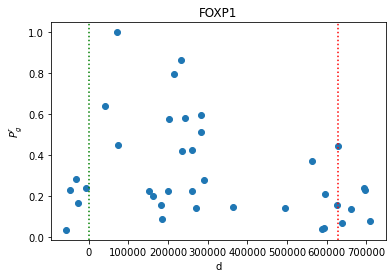

In [72]:
gene_name="FOXP1"
gene_num=df_genes_regions["gene_number"][df_genes_regions["gene_name"]==gene_name].iloc[0]
m_lam_=m_lam/m_lam.sum(axis=0)
m_phi_=m_phi/m_phi.sum(axis=0)
p_phi=0
df_gene_regions_all_topic=df_genes_regions[df_genes_regions["gene_name"]==gene_name]
i=0
num_regions=df_genes_regions[df_genes_regions["gene_name"]==gene_name]["region_number"].shape[0]
corr=np.zeros(num_regions)
distance=np.zeros(num_regions)
distance_end=np.zeros(num_regions)
for n in np.arange(0,num_regions):
    region_num=df_gene_regions_all_topic["region_number"].iloc[n]
 
    p_phi=torch.multiply(m_phi_[:,region_num],m)
    
    corr[i]=torch.multiply(p_phi,m_lam_[:,gene_num]).sum(axis=0).sum(axis=0).numpy()
    distance[i]=df_gene_regions_all_topic["start_region"].iloc[n]
    i+=1
    
corr=corr/theta.shape[1]
plt.scatter(x=distance-df_gene_regions_all_topic["start_gene"].iloc[n],y=corr/corr.max())
plt.axvline(x=0, ymin=0, ymax=10,color='green', linestyle='dotted')
plt.axvline(x=df_gene_regions_all_topic["end_gene"].iloc[n]-df_gene_regions_all_topic["start_gene"].iloc[n]
            , ymin=0, ymax=10,color='red', linestyle='dotted')
plt.ylabel("$P_g^r$")
plt.xlabel("d")
plt.title(gene_name)

In [77]:
gene_list=list(df_genes_regions["gene_name"].drop_duplicates())
distance_list=[]
coor_list=[]
gene_pos=np.zeros(len(gene_list))
for l,gene in enumerate(gene_list):
  if df_genes_regions[df_genes_regions["gene_name"]==gene].shape[0]!=0:
    gene_num=df_genes_regions["gene_number"][df_genes_regions["gene_name"]==gene].iloc[0]
    x=df_genes_regions["gene_name"]==gene
    num_regions=df_genes_regions[x]["region_number"].shape[0]
    regions_num=df_genes_regions[x]["region_number"].values
    regions_begin=df_genes_regions[x]["start_region"].values
    distance_begin=df_genes_regions[x]["start_gene"]
    p_phi=m_phi_[:,regions_num]
    p_phi=torch.multiply(m[:,:,None],p_phi[None,:,:])
    corr=torch.multiply(p_phi,m_lam_[:,gene_num][None,:,None]).sum(axis=0).sum(axis=0)
    coor_list.append(corr)
    gene_pos[l]=distance_begin.iloc[0]
    distance_list.append(distance_begin-regions_begin)

        

Text(0.5, 0, 'd')

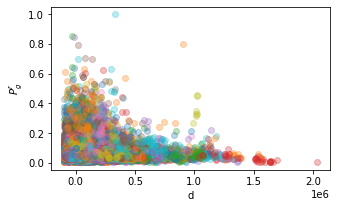

In [78]:
max_corr=max(max(inner_list) for inner_list in coor_list)
plt.figure(figsize = (5,3))
for i,j in enumerate(gene_pos[:len(distance_list)]):
    plt.scatter(x=distance_list[i]*(-1), y=coor_list[i]/max_corr,alpha=0.3) 
plt.ylabel("$P_g^r$")
plt.xlabel("d")

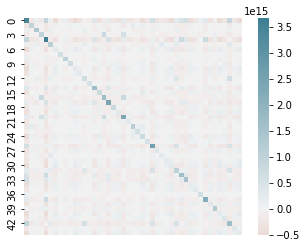

In [80]:
m_lam_norm=(m_lam-m_lam.mean(axis=0))/m_lam.var(axis=0)
m_phi_norm=(m_phi-m_phi.mean(axis=0))/m_phi.var(axis=0)
m_all=torch.concat((m_lam_norm,m_phi_norm),axis=1)
corr_all=torch.matmul(m_all,m_all.T)
ax = sns.heatmap(
    corr_all, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    ,xticklabels=False
)